# My Proposed TDI Capstone Project

BACKGROUND: Parkinsons is a debilitating illness and patients suffer from impaired walking gait, which can lead to falling and reduced quality of life. 

PROBLEM: A common PD symptom is freezing during walking, which occurs much more often during daily life than during a doctors visit.
It would be convenient to remotely monitor symptoms of abnormal walking gait o better track progression of the disease

AIM: 
Use accelerometer data to detect abnormal gait patterns in Parkinson’s patients using a machine learning approach.

This can potentially provide additional information to clinicians when recommending treatment options. 


# Import all libraries 

In [822]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import glob, os

import tensorflow as tf
from keras.layers import BatchNormalization
from tensorflow import keras
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# Load dataset


Public dataset available on UCI - The Daphnet Freezing of Gait Dataset in patients with Parkinson disease.

Accelerometer measurements were collected from 10 participants wearing sensors on the ankle, leg, and hip and freezing gait was labeled by expert clinicians. 


In [757]:
participant_file_names = []
participants = []

for file in glob.glob("*.txt"):
    participant_file_names.append(np.genfromtxt(file, delimiter=''))
    participants.append(np.genfromtxt(file, delimiter=''))

## What does the data look like for one participant exhibiting freezing episodes?

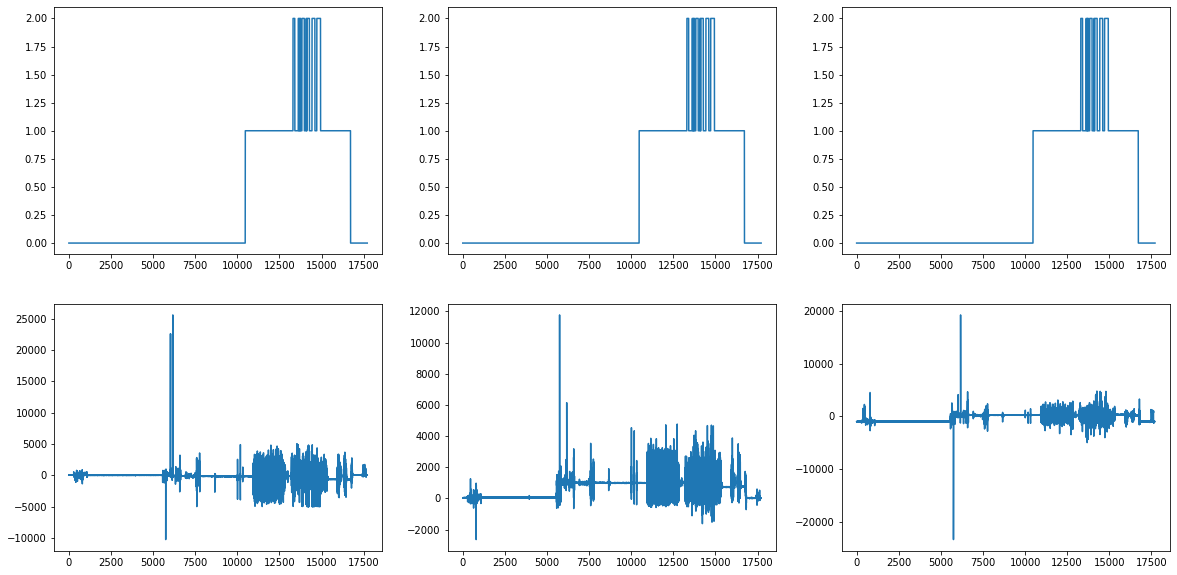

In [769]:
fig, ax = plt.subplots(2, 3)
ax[1, 0].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, 1])
ax[1, 1].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, 2])
ax[1, 2].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, 3])

ax[0, 0].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, -1])
ax[0, 1].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, -1])
ax[0, 2].plot(participants[1][:, 0]*(1.0/64.0), participants[1][:, -1])

# Split the participants into train, validation, and test sets
We must split the participants such that the fraction of freezing events are the same across train, validation, and test sets

Find the set of indicies that produces similar class ratio across splits.

In [721]:
indices = np.random.permutation(len(participants_train))


In [722]:
# test1 = []
# for i in indices[:-2]:
#     test = pd.Series(participants_train[i][:, -1])
#     test1.append(test.value_counts())
# test1 = pd.concat(test1)   
# test3 = pd.DataFrame(test1).reset_index()
# table = test3.groupby('index')[0].sum()

In [723]:
# table[2]/(table[1] + table[2])

0.09340543310879268

In [724]:
# test1 = []
# for i in indices[-2:]:
#     test = pd.Series(participants_train[i][:, -1])
#     test1.append(test.value_counts())
    
# test1 = pd.concat(test1)
# test3 = pd.DataFrame(test1).reset_index()
# table = test3.groupby('index')[0].sum()

In [725]:
# table[2]/(table[1] + table[2])

0.10988063692957235

In [777]:
train_test_indices = [ 3, 15,  0,  1, 13,  4, 11, 12,  6, 16, 10,  9,  5, 14,  7,  8,  2]

In [778]:
participants_train = [participants[i] for i in train_test_indices[:-2]]
participants_test = [participants[i] for i in train_test_indices[-2:]]

In [779]:
train_val_indices = [11,  4,  7, 12,  6,  9,  3, 10,  8,  2,  5,  1,  0, 14, 13]

In [780]:
participants_train, participants_val = [participants_train[i] for i in train_val_indices[:-2]], [participants_train[i] for i in train_val_indices[-2:]]

## Define window size for time series 

Extract repeated observations of 0.5 s of accelerometer data and an associated class label (freeze or not freeze)

I will use a window of prior observations in the x, y, z accelerometer time series data with which to predict the current class. I will concatenate the windows for each participant to build the X matrix for the model.


In [823]:
# the sample rate is 64 Hz so a window size of 32 is 0.5 s
window_size = 64

In [824]:
def series_to_supervised(participant_list, window_size=64):
    x, y, z = [], [], []
    class_ = []
    for k in range(len(participant_list)):
        participant = pd.DataFrame(participant_list[k])

        participant.columns = ["time", "x1", "y1", "z1", "x2", "y2", "z2", "x3", "y3", "z3", "class"]
        
        participant.drop(participant[(participant['class'] == 0)].index, inplace=True) 
        x_participant = pd.concat([participant['x1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()
        y_participant = pd.concat([participant['y1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()
        z_participant = pd.concat([participant['z1'].shift(i) for i in range(window_size, 0, -1)], axis=1).dropna()

        x.append(x_participant)
        y.append(y_participant)
        z.append(z_participant)

        class_.append(participant['class'][window_size:])

    class_ = pd.concat(class_)
    
    x = np.vstack(x)
    y = np.vstack(y)
    z = np.vstack(z)
    X = np.stack((x, y, z), axis=2)
    
    X = X.squeeze()
    
    y = class_
    
    return X, y.to_numpy()

In [825]:
X_train, y_train = series_to_supervised(participants_train)
X_val, y_val = series_to_supervised(participants_val)
X_test, y_test = series_to_supervised(participants_test)

In [826]:
shuffled_train_inds = np.random.permutation((X_train.shape[0]))
X_train, y_train = X_train[shuffled_train_inds, :, :], y_train[shuffled_train_inds]

shuffled_val_inds = np.random.permutation((X_val.shape[0]))
X_val, y_val = X_val[shuffled_val_inds, :, :], y_val[shuffled_val_inds]

shuffled_test_inds = np.random.permutation((X_test.shape[0]))
X_test, y_test = X_test[shuffled_test_inds, :, :], y_test[shuffled_test_inds]

## Check that class distribution is similar between train, validation and test sets

In [827]:
df = pd.DataFrame(y_train).reset_index()
df.columns= ['index', 'target']
target_count = df.target.value_counts()
for index, row in target_count.items():
    print('Proportion class {}:{}'.format(index, round(row / np.sum(target_count), 4)))

Proportion class 1.0:0.9065
Proportion class 2.0:0.0935


In [828]:
df = pd.DataFrame(y_val).reset_index()
df.columns= ['index', 'target']
target_count = df.target.value_counts()
for index, row in target_count.items():
    print('Proportion class {}:{}'.format(index, round(row / np.sum(target_count), 4)))
    
#target_count.plot(kind='bar', title='Count (target)');

Proportion class 1.0:0.8901
Proportion class 2.0:0.1099


In [829]:
df = pd.DataFrame(y_test).reset_index()
df.columns= ['index', 'target']
target_count = df.target.value_counts()
for index, row in target_count.items():
    print('Proportion class {}:{}'.format(index, round(row / np.sum(target_count), 4)))
    

Proportion class 1.0:0.8973
Proportion class 2.0:0.1027


## Encoding the target variable
1. convert target variables to 0 and 1
2. convert 0 and 1 class vector to binary class matrix since we are assigning probabilities to each class
(0 = not freezing and 1 = freezing)

In [830]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(y_train)
y_train = to_categorical(encoded_Y)

encoded_Y = encoder.fit_transform(y_val)
y_val = to_categorical(encoded_Y)

# CNN Model building 

Define a 1D CNN model to find the function mapping each set of x, y, z accelerometer windows into associated class label

In [831]:
n_filters = 32
filter_size = 5
pool_size = 2
num_sensors = 3

In [832]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [833]:
tf.keras.backend.clear_session()

In [834]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    #tf.keras.Input(input_shape=(TIME_PERIODS,num_sensors)),
    tf.keras.layers.Reshape((window_size,  num_sensors), input_shape=(window_size, num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='same',input_shape=(window_size, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='same', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
 
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 3)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 3)             12        
_________________________________________________________________
conv1 (Conv1D)               (None, 64, 32)            512       
_________________________________________________________________
conv2 (Conv1D)               (None, 64, 32)            5152      
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 32, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

# Train the CNN model using the train and validation sets

In [840]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping. Stop training based 
#                                                                             # on your measured validation loss to 
#                                                                             # catch your model just as it’s about 
#                                                                             # to overfit.
            

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weights = {0:1, 1:100}
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=64,
                    callbacks=[early_stopping], verbose=1)


Epoch 1/20
13158/13158 [==============================] - 156s 12ms/step - loss: 0.0790 - tp: 816303.0000 - fp: 25771.0000 - tn: 816303.0000 - fn: 25771.0000 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9959 - prc: 0.9958 - val_loss: 0.5425 - val_tp: 175854.0000 - val_fp: 28185.0000 - val_tn: 175854.0000 - val_fn: 28185.0000 - val_accuracy: 0.8619 - val_precision: 0.8619 - val_recall: 0.8619 - val_auc: 0.9268 - val_prc: 0.9143
Epoch 2/20
13158/13158 [==============================] - 161s 12ms/step - loss: 0.0718 - tp: 819207.0000 - fp: 22867.0000 - tn: 819207.0000 - fn: 22867.0000 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9965 - prc: 0.9964 - val_loss: 0.5226 - val_tp: 178040.0000 - val_fp: 25999.0000 - val_tn: 178040.0000 - val_fn: 25999.0000 - val_accuracy: 0.8726 - val_precision: 0.8726 - val_recall: 0.8726 - val_auc: 0.9352 - val_prc: 0.9249
Epoch 3/20
13158/13158 [==============================] - 164s 12ms/step - loss: 0.0681 - tp: 8207

## Plot the train and validation training curves to confirm that the model didn't overfit to the training set.
The fitting is stopped when the validation loss no longer decreases

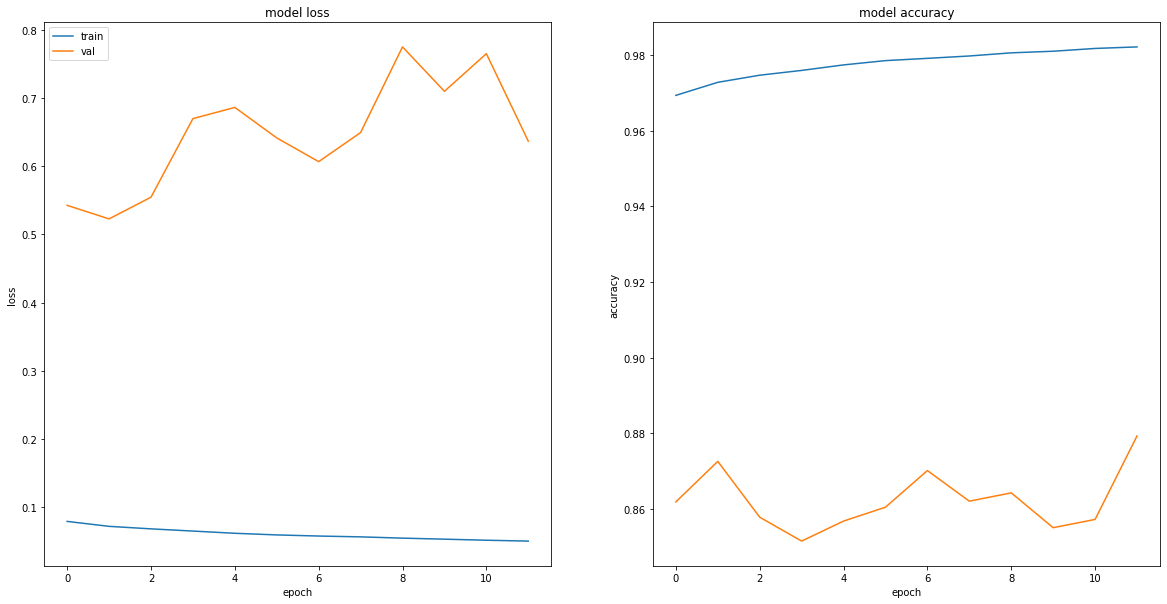

In [841]:
# summarize history for loss and accuracy
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
plt.show()

# Evaluate the model performance on the held-out test set

In [853]:
# Convert the y-test class labels to a binary matrix for assigning probabilities
encoded_Y = encoder.fit_transform(y_test)
y_test = to_categorical(encoded_Y)

## Use the confusion matrix to understand how well we did at detecting freeze events and what type of errors we made

In [854]:
from sklearn.metrics import confusion_matrix

In [855]:
predictions = (model.predict(X_test) > 0.5).astype(int)


In [856]:
conf_mat = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1))
print('Confusion matrix:\n', np.round(conf_mat/np.sum(conf_mat, axis=0), 2))

Confusion matrix:
 [[0.96 0.43]
 [0.04 0.57]]


## Display a concise summary of the performance of the CNN classifier 

In [857]:
print(classification_report(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     84015
           1       0.57      0.65      0.61      9619

    accuracy                           0.91     93634
   macro avg       0.77      0.80      0.78     93634
weighted avg       0.92      0.91      0.92     93634



In [859]:
# results = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)


# Summary of preliminary results:

Since the cost of not detecting a freeze is high and the cost of labeling a normal gait as a freeze is also high, and I am more interested in detecting freeze events than normal gaits, I evaluated the F1-score on the test set. F1 combines both precision and recall.

On the hold out test set, the model achieved an F1-score of 61%, meaning when the model predicts someone has freezing gait, it’s precise and doesn’t miss too many freezes

